In [1]:
import os, re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
!pip install transformers tika

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 2.7 MB/s eta 0:00:00
  Created wheel for tika: filename=tika-2.6.0-py3-none-any.whl size=32641 sha256=7af27683c6e1184a76e28e0cf7709bd51b804743318a7d049f6e824d33897bb9
  Stored in directory: /root/.cache/pip/wheels/13/56/18/e752060632d32c39c9c4545e756dad281f8504dafcfac02b95
Successfully built tika


In [3]:
from transformers import BertTokenizer, TFBertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

model.summary()

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "tf_bert_for_masked_lm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  24459834  
                                                                 
Total params: 109,514,298
Trainable params: 109,514,298
Non-trainable params: 0
_________________________________________________________________


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd drive/MyDrive/indexed_corpus

/content/drive/.shortcut-targets-by-id/1X1APgHBDiD-6ucORNx5eM_SWKZYOgyvz/indexed_corpus


In [6]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from tika import parser
import re

sentences = []

for i in range(1, 16):
    
    pdf_path = str(i) + ".pdf"
    parsed_pdf = parser.from_file(pdf_path)
    
    pdf_content = parsed_pdf['content'].replace('\n', ' ').strip()
    pdf_content = re.sub("\s\s+", " ", pdf_content)
    pdf_content = re.sub(r'\.+', ".", pdf_content)
    
    pdf_sentence = sent_tokenize(pdf_content)
    sentences += pdf_sentence

len(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2023-04-06 21:50:16,929 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar to /tmp/tika-server.jar.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar to /tmp/tika-server.jar.
2023-04-06 21:50:17,489 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar.md5 to /tmp/tika-server.jar.md5.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar.md5 to /tmp/tika-server.jar.md5.
2023-04-06 21:50:17,963 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


15584

In [7]:
inputs = tokenizer(sentences, max_length=100, truncation=True, padding='max_length', return_tensors='tf')
inputs['labels'] = inputs['input_ids']
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [8]:
import numpy as np

inp_ids = []

for inp in inputs.input_ids.numpy():
    actual_tokens = list(set(range(len(inp))) - set(np.where((inp == 101) | (inp == 102) | (inp == 0))[0].tolist()))
        
    # Select 15% random tokens from the given list
    num_of_token_to_mask = max(1, int(len(actual_tokens) * 0.15))
    token_to_mask = np.random.choice(np.array(actual_tokens), size=num_of_token_to_mask, replace=False).tolist()
    
    # Now we have the indices where we need to mask the tokens
    inp[token_to_mask] = 103
    inp_ids.append(inp)

inputs['input_ids'] = tf.convert_to_tensor(np.asarray(inp_ids))

In [9]:
epochs = 10
batch_size = 16

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    )

history = model.fit(
    [inputs.input_ids, inputs.attention_mask], 
    inputs.labels, 
    verbose=1, 
    batch_size=batch_size, 
    epochs=epochs
    )

Epoch 1/10
974/974 [==============================] - 430s 393ms/step - loss: 0.1915
Epoch 2/10
974/974 [==============================] - 386s 396ms/step - loss: 0.0708
Epoch 3/10
974/974 [==============================] - 386s 396ms/step - loss: 0.0402
Epoch 4/10
974/974 [==============================] - 385s 396ms/step - loss: 0.0237
Epoch 5/10
974/974 [==============================] - 386s 396ms/step - loss: 0.0151
Epoch 6/10
974/974 [==============================] - 386s 396ms/step - loss: 0.0129
Epoch 7/10
974/974 [==============================] - 386s 396ms/step - loss: 0.0208
Epoch 8/10
974/974 [==============================] - 386s 396ms/step - loss: 0.0061
Epoch 9/10
974/974 [==============================] - 386s 396ms/step - loss: 0.0053
Epoch 10/10
974/974 [==============================] - 385s 396ms/step - loss: 0.0082


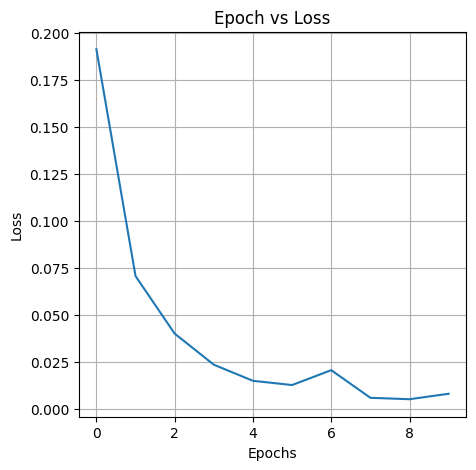

In [10]:
losses = history.history['loss']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)), losses)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

In [11]:
model.save_weights('/content/drive/MyDrive/fine_tuned_model_weights_all_reports.h5')

In [12]:
input_ids = tokenizer("Hello, my dog is cute", return_tensors="tf")["input_ids"]
input_ids

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]],
      dtype=int32)>

In [13]:
outputs = model(input_ids, labels=input_ids, output_hidden_states=True)
outputs[2][0].shape

TensorShape([1, 8, 768])